# Network Analysis

Created: 14/05/2024

Last updated: 08/07/2024

Created by: Alisea Stroligo

In [ ]:
#before running script: EXTRACT FILES FROM "data" FOLDER

In [3]:
#SETUP CELL

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

#import warnings
#warnings.filterwarnings('ignore')


In [4]:
# LOADING combined DATASET of topic and sentiment analysis results on chosen subreddit
topsent_df = pd.read_csv("data/webis_tldr_subreddit(topic+sentiment).csv")

topsent_df.head()

,author,body,normalizedBody,subreddit,subreddit_id,id,content_x,summary,Topic,content_y,vader_score,afinn_score,vader_sentiment,afinn_sentiment
0,Cypriotmenace,Think of it like mailing pages of a book to di...,Think of it like mailing pages of a book to di...,explainlikeimfive,t5_2sokd,c6dydfx,think of it like mailing pages of a book to di...,"always look for the highest seeded torrents, a...",Telecommunications Infrastructure,think of it like mailing pages of a book to di...,0.6808,3.0,positive,positive
1,senatorskeletor,"""Redistribution"" is short for ""redistribution ...","""Redistribution"" is short for ""redistribution ...",explainlikeimfive,t5_2sokd,c6whsmv,"redistribution"" is short for ""redistribution o...",1) using the tax system to take money from the...,Political Ideologies and Economic Systems,"redistribution"" is short for ""redistribution o...",0.9874,23.0,positive,positive
2,callumgg,"The Chinese system isn't exactly transparent, ...","The Chinese system isn't exactly transparent, ...",explainlikeimfive,t5_2sokd,c6y9grw,"the chinese system isn't exactly transparent, ...",2700 delegates and representatives from all ov...,Political Parties and Elections,"the chinese system isn't exactly transparent, ...",0.9330,11.0,positive,positive
3,mcanerin,Here is an analogy I've used before and might ...,Here is an analogy I've used before and might ...,explainlikeimfive,t5_2sokd,c6yj68l,here is an analogy i've used before and might ...,"the communist party isn't a political party, i...",Political Ideologies and Economic Systems,here is an analogy i've used before and might ...,0.9916,17.0,positive,positive
4,neo45,"This is a complicated question, but I think it...","This is a complicated question, but I think it...",explainlikeimfive,t5_2sokd,c7fuozw,"this is a complicated question, but i think it...","there's lots of good actors out there, but ver...",Cinema and Filmmaking,"this is a complicated question, but i think it...",0.9891,36.0,positive,positive


In [5]:
# DATA CLEANING
df_filtered = topsent_df.copy()

#filtering empty or nan or uninformative content
df_filtered  = df_filtered.dropna()
df_filtered  = df_filtered [~df_filtered ['vader_sentiment'].str.contains('\d+', regex=True)]
df_filtered = df_filtered[df_filtered['author'] != '[deleted]']

#filtering out duplicates (same content by same user)
df_filtered.drop_duplicates(subset=['author', 'content_x'], keep=False, inplace=True)

df_filtered = df_filtered.sample(1000) #selecting a random sample from the complete dataset for visualization purposes


C:\Users\AS\AppData\Local\Temp\ipykernel_22192\810080082.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  avg_sentiment = reduced_df.replace({'vader_sentiment': sentiment_mapping}).groupby('author')['vader_sentiment'].mean().apply(average_to_sentiment)


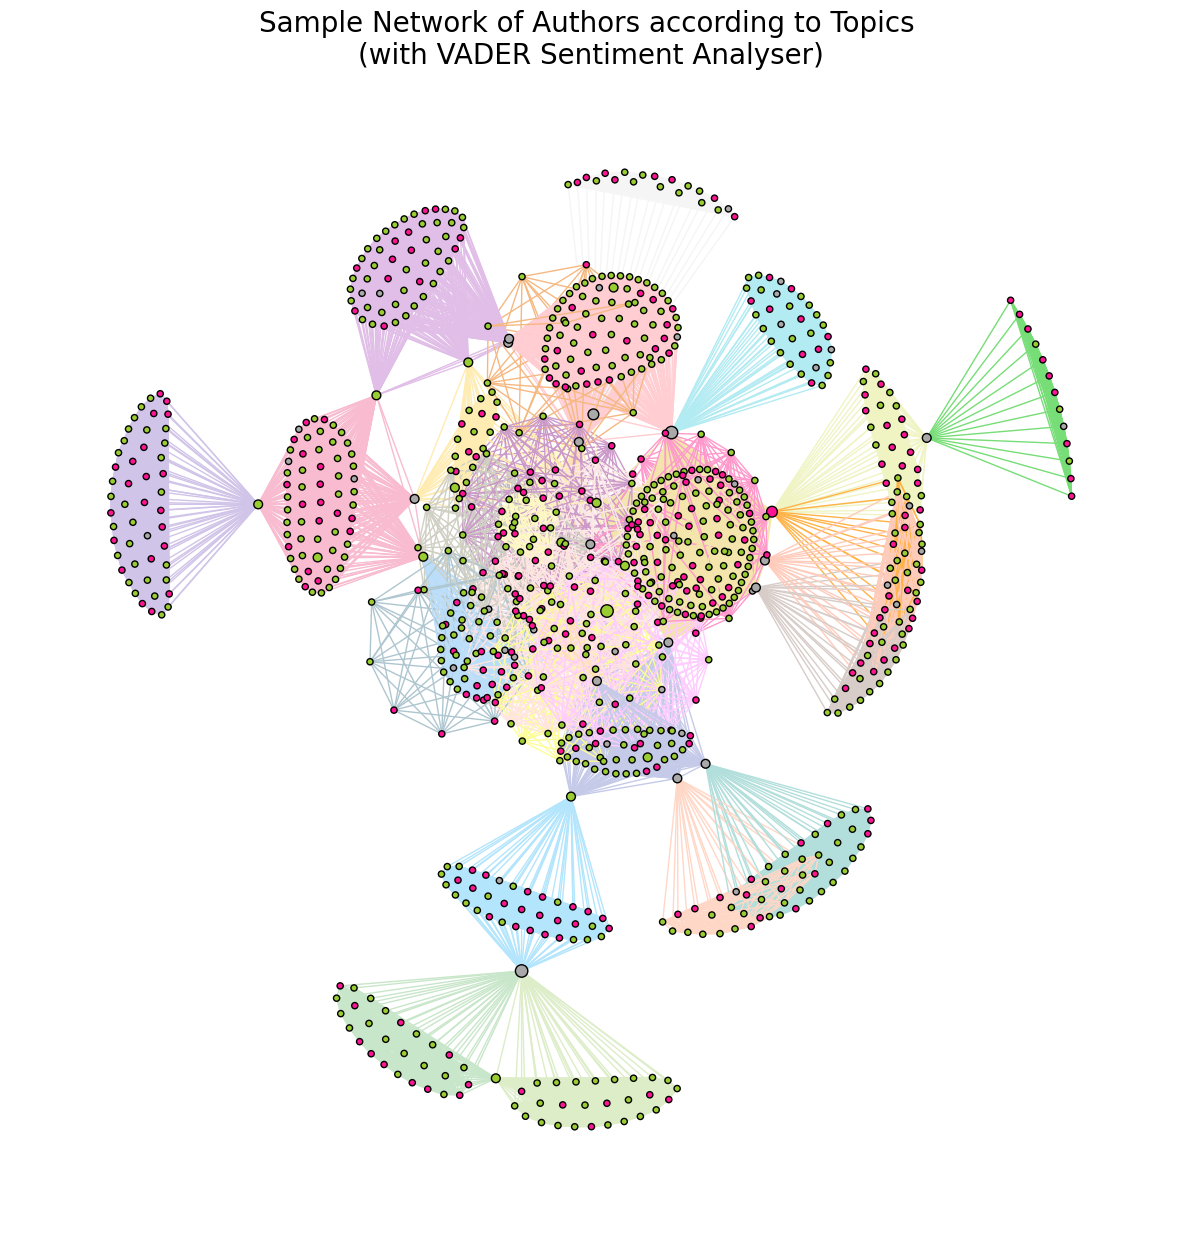

C:\Users\AS\AppData\Local\Temp\ipykernel_22192\810080082.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  markerfacecolor='black', label=f'Most active user (in sample): {top_authors[0]} posts')


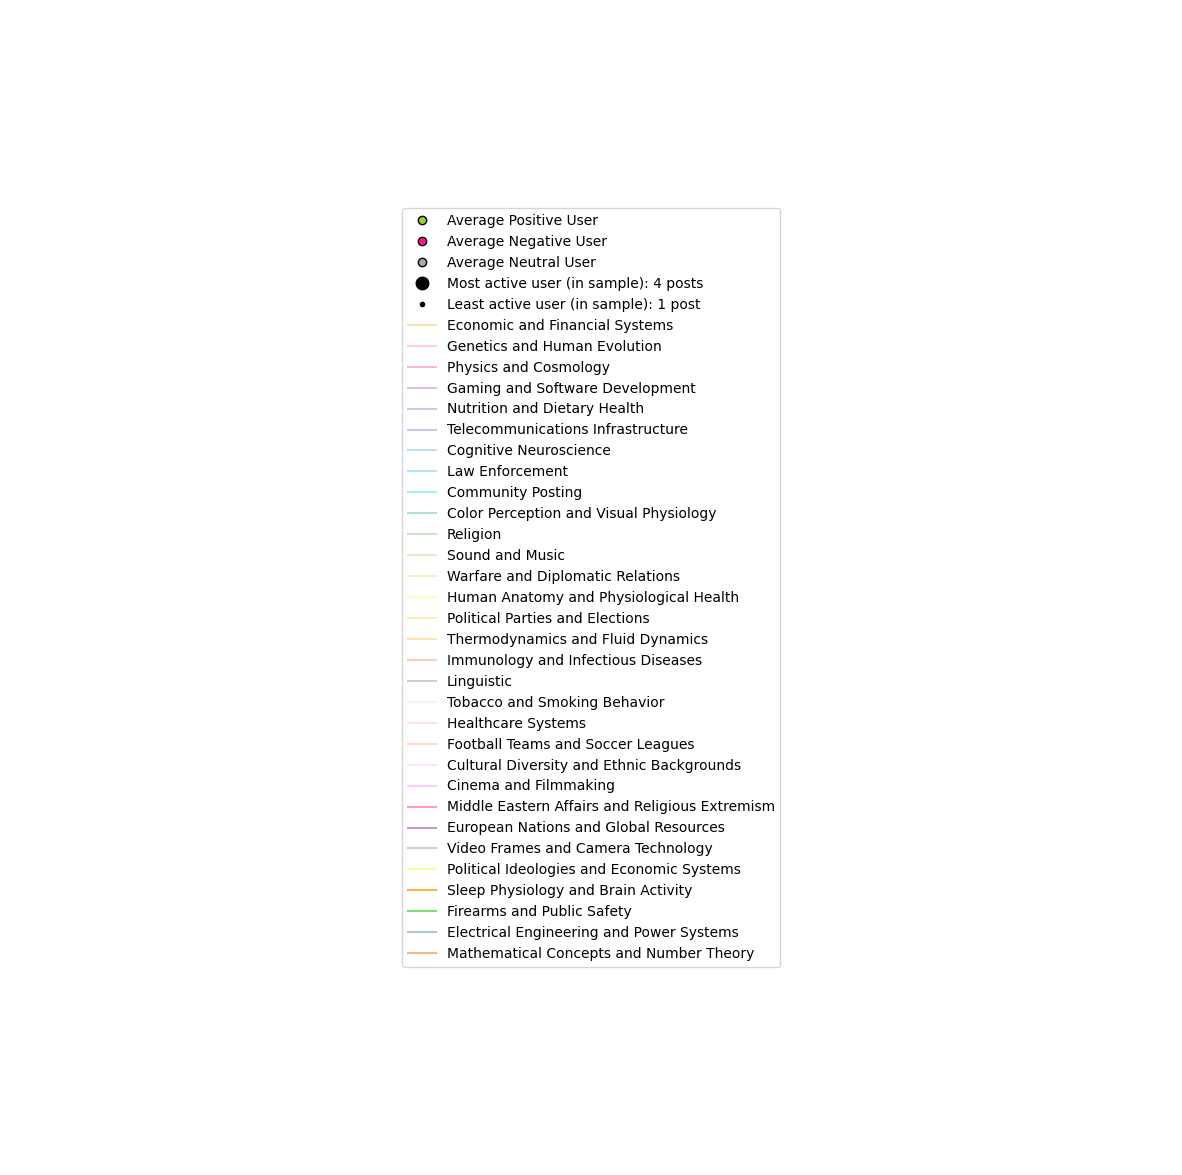

In [6]:
# NETWORK OF USER CLUSTERS DEPENDING ON TOPIC

#Version 1: VADER
plt.figure(1,figsize=(15,15)) 

# selecting subreddit topics
top_topics = df_filtered['Topic'].value_counts()
top_topics = pd.DataFrame({'topic':top_topics.index, 'count':top_topics.values})
topics_list  = top_topics['topic'].unique() 
reduced_df = df_filtered[df_filtered['Topic'].isin(topics_list)]

# creating network graph
vader_graph = nx.Graph()

# Adding nodes with sentiment as attribute
# node size determined by the number of occurrences (i.e. posts) of the author
author_counts = reduced_df['author'].value_counts().to_dict()
authors = reduced_df['author'].unique()
sentiment_colormap = {'positive': 'yellowgreen', 'neutral': 'darkgrey', 'negative': 'deeppink'}
#calculating average sentiment of posts for each user/author
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
def average_to_sentiment(avg):
    if avg < 0.5:
        return 'negative'
    elif avg < 1.5:
        return 'neutral'
    else:
        return 'positive'
avg_sentiment = reduced_df.replace({'vader_sentiment': sentiment_mapping}).groupby('author')['vader_sentiment'].mean().apply(average_to_sentiment)
avg_sentimentdf = pd.DataFrame({'author':avg_sentiment.index, 'vader_sentiment':avg_sentiment.values})
# creating nodes
for idx, author in enumerate(authors):
    curr_sentiment = avg_sentimentdf.loc[avg_sentimentdf['author'] == author, 'vader_sentiment'].iloc[0]
    vader_graph.add_node(author, size=author_counts[author], sentiment=sentiment_colormap[curr_sentiment])

# Adding edges with topic as an attribute
#topic_colors = sns.color_palette("pastel", len(topics_list))
topic_colors = ["#F3E5AB", "#FFCDD2","#F8BBD0",  "#E1BEE7",  "#D1C4E9",  "#C5CAE9",  "#BBDEFB", "#B3E5FC",  "#B2EBF2",  "#B2DFDB",  "#C8E6C9",  "#DCEDC8",  "#F0F4C3",  "#FFF9C4",  
"#FFECB3", "#FFE0B2", "#FFCCBC", "#D7CCC8","#F5F5F5", "#FFE4E1", "#FFD7C7", "#FBE9E7", "#FFCCFF","#FF99CC", "#CB99C9", "#CFCFC4","#FDFD96","#FFB347","#77DD77", "#AEC6CF","#F6B881"]
for idx,topic in enumerate(topics_list):
    curr_topic_color = topic_colors[idx] 
    authors_in_topic = reduced_df[reduced_df['Topic'] == topic]['author'].unique()
    for i, author1 in enumerate(authors_in_topic):
        temp_authors2 = np.delete(authors_in_topic, i)
        for idx2 in range(len(temp_authors2)):
            author2 = temp_authors2[idx2]
            vader_graph.add_edge(author1, author2, weight=0.3,color=curr_topic_color,width=0.01)

# node position
pos = nx.kamada_kawai_layout(vader_graph)

# drawing nodes
sizes = [vader_graph.nodes[node]['size'] * 20 for node in vader_graph.nodes] 
colors = [vader_graph.nodes[node]['sentiment'] for node in vader_graph.nodes]
nx.draw_networkx_nodes(vader_graph, pos, node_size=sizes, node_color=colors, edgecolors='black')

# drawing edges
edges = vader_graph.edges()
edge_colors = [vader_graph[u][v]['color'] for u,v in edges]
nx.draw_networkx_edges(vader_graph, pos, edge_color=edge_colors)

plt.title('Sample Network of Authors according to Topics \n(with VADER Sentiment Analyser)',fontsize=20)
plt.axis('off')
#plt.savefig('../../figures/AuthorNetworkGraph_Topics+VADER.jpg') #saving figure
#plt.savefig('../../dashboard/AuthorNetworkGraph_Topics+VADER.jpg') #saving figure
plt.show()


#creating legend: plot invisible markers for legend
plt.figure(2,figsize=(15,15)) 
top_authors = df_filtered['author'].value_counts()
plt.plot([], [], color='none', marker='o', markersize=6, 
                          markerfacecolor='yellowgreen',markeredgecolor='black',label=f'Average Positive User')
plt.plot([], [], color='none', marker='o', markersize=6, 
                          markerfacecolor='deeppink',markeredgecolor='black',label=f'Average Negative User')
plt.plot([], [], color='none', marker='o', markersize=6, 
                          markerfacecolor='darkgrey',markeredgecolor='black',label=f'Average Neutral User')
plt.plot([], [], color='none', marker='o', markersize=9, 
                          markerfacecolor='black', label=f'Most active user (in sample): {top_authors[0]} posts')
plt.plot([], [], color='none', marker='o', markersize=3, 
                          markerfacecolor='black', label=f'Least active user (in sample): 1 post')
for i in range(len(topics_list)):
    plt.plot([], [], color=topic_colors[i], markersize=10, label=topics_list[i], linestyle='solid')[0]
plt.legend(loc='center')


plt.axis('off')
#plt.savefig('../../figures/Legend_AuthorNetworkGraph.jpg') #saving legend
#plt.savefig('../../dashboard/Legend_AuthorNetworkGraph.jpg') #saving legend
plt.show()

C:\Users\AS\AppData\Local\Temp\ipykernel_22192\3458483412.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  avg_sentiment = reduced_df.replace({'afinn_sentiment': sentiment_mapping}).groupby('author')['afinn_sentiment'].mean().apply(average_to_sentiment)


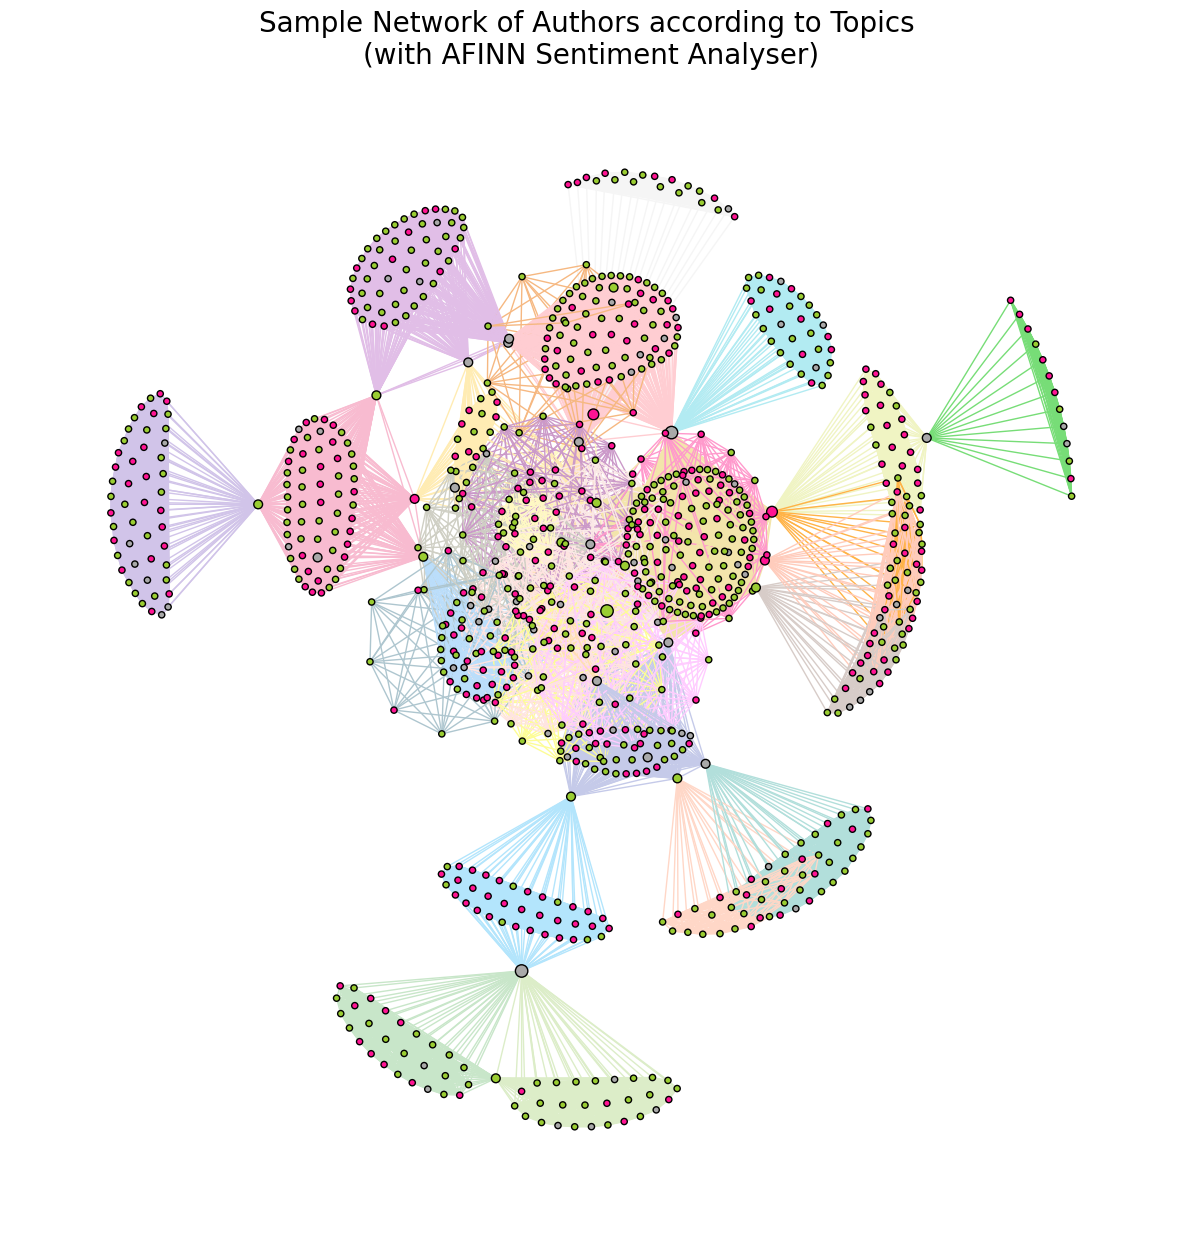

C:\Users\AS\AppData\Local\Temp\ipykernel_22192\3458483412.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  markerfacecolor='black', label=f'Most active user: {top_authors[0]} posts')


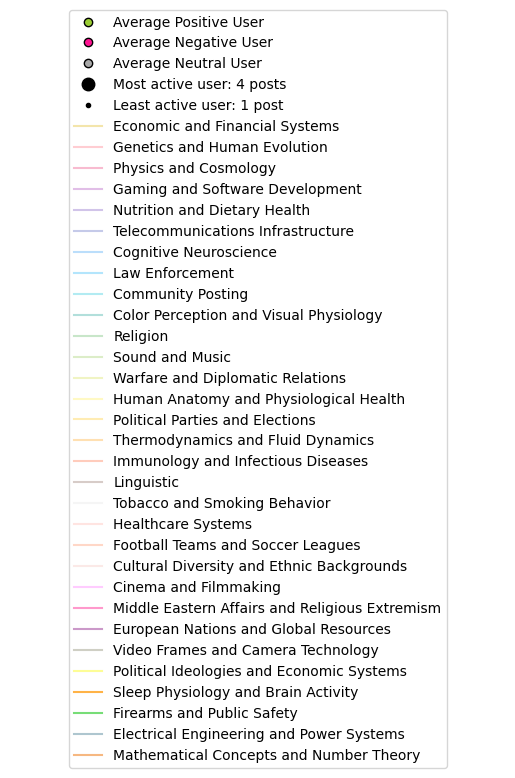

In [7]:
# NETWORK OF USER CLUSTERS DEPENDING ON TOPIC

#Version 2: AFINN
plt.figure(3,figsize=(15,15)) 

# selecting subreddit topics
top_topics = df_filtered['Topic'].value_counts()
top_topics = pd.DataFrame({'topic':top_topics.index, 'count':top_topics.values})
topics_list  = top_topics['topic'].unique()
reduced_df = df_filtered[df_filtered['Topic'].isin(topics_list)]

# creating network graph
afinn_graph = nx.Graph()

# Adding nodes with sentiment as attribute
# node size determined by the number of occurrences (i.e. posts) of the author
author_counts = reduced_df['author'].value_counts().to_dict()
authors = reduced_df['author'].unique()
sentiment_colormap = {'positive': 'yellowgreen', 'neutral': 'darkgrey', 'negative': 'deeppink'}
#calculating average sentiment of posts for each user/author
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
def average_to_sentiment(avg):
    if avg < 0.5:
        return 'negative'
    elif avg < 1.5:
        return 'neutral'
    else:
        return 'positive'
avg_sentiment = reduced_df.replace({'afinn_sentiment': sentiment_mapping}).groupby('author')['afinn_sentiment'].mean().apply(average_to_sentiment)
avg_sentimentdf = pd.DataFrame({'author':avg_sentiment.index, 'afinn_sentiment':avg_sentiment.values})
# creating nodes
for idx, author in enumerate(authors):
    curr_sentiment = avg_sentimentdf.loc[avg_sentimentdf['author'] == author, 'afinn_sentiment'].iloc[0]
    afinn_graph.add_node(author, size=author_counts[author], sentiment=sentiment_colormap[curr_sentiment])

# Adding edges with topic as an attribute
#topic_colors = sns.color_palette("pastel", len(topics_list))
topic_colors = ["#F3E5AB", "#FFCDD2","#F8BBD0",  "#E1BEE7",  "#D1C4E9",  "#C5CAE9",  "#BBDEFB", "#B3E5FC",  "#B2EBF2",  "#B2DFDB",  "#C8E6C9",  "#DCEDC8",  "#F0F4C3",  "#FFF9C4",  
"#FFECB3", "#FFE0B2", "#FFCCBC", "#D7CCC8","#F5F5F5", "#FFE4E1", "#FFD7C7", "#FBE9E7", "#FFCCFF","#FF99CC", "#CB99C9", "#CFCFC4","#FDFD96","#FFB347","#77DD77", "#AEC6CF","#F6B881"]
for idx,topic in enumerate(topics_list):
    curr_topic_color = topic_colors[idx] 
    authors_in_topic = reduced_df[reduced_df['Topic'] == topic]['author'].unique()
    for i, author1 in enumerate(authors_in_topic):
        temp_authors2 = np.delete(authors_in_topic, i)
        #rand_authors2 = random.sample(list(temp_authors2),3) #get a random sample for visualization purposes
        for idx2 in range(len(temp_authors2)):
            author2 = temp_authors2[idx2]
            afinn_graph.add_edge(author1, author2, weight=0.3,color=curr_topic_color,width=0.01)

# node position
pos = nx.kamada_kawai_layout(afinn_graph)

# drawing nodes
sizes = [afinn_graph.nodes[node]['size'] * 20 for node in afinn_graph.nodes] 
colors = [afinn_graph.nodes[node]['sentiment'] for node in afinn_graph.nodes]
nx.draw_networkx_nodes(afinn_graph, pos, node_size=sizes, node_color=colors, edgecolors='black')

# drawing edges
edges = afinn_graph.edges()
edge_colors = [afinn_graph[u][v]['color'] for u,v in edges]
nx.draw_networkx_edges(afinn_graph, pos, edge_color=edge_colors)


plt.title('Sample Network of Authors according to Topics \n(with AFINN Sentiment Analyser)',fontsize=20)
plt.axis('off')
#plt.savefig('../../figures/AuthorNetworkGraph_Topics+AFINN.jpg') #saving figure
plt.show()

# creating legend: plot invisible markers for legend
top_authors = reduced_df['author'].value_counts()
plt.plot([], [], color='none', marker='o', markersize=6, 
                          markerfacecolor='yellowgreen',markeredgecolor='black',label=f'Average Positive User')
plt.plot([], [], color='none', marker='o', markersize=6, 
                          markerfacecolor='deeppink',markeredgecolor='black',label=f'Average Negative User')
plt.plot([], [], color='none', marker='o', markersize=6, 
                          markerfacecolor='darkgrey',markeredgecolor='black',label=f'Average Neutral User')
plt.plot([], [], color='none', marker='o', markersize=9, 
                          markerfacecolor='black', label=f'Most active user: {top_authors[0]} posts')
plt.plot([], [], color='none', marker='o', markersize=3, 
                          markerfacecolor='black', label=f'Least active user: 1 post')
for i in range(len(topics_list)):
    plt.plot([], [], color=topic_colors[i], markersize=10, label=topics_list[i], linestyle='solid')[0]
plt.legend(loc='center')


plt.axis('off')
plt.show()